# Colombian Bond Clustering: Leveraging KMeans for Data Cleaning and Classification

Project by: **Simon Hoyos**

For this project, we gathered data on Colombian Government and Corporate Bonds from the Bloomberg Terminal. Our goal is to clean up this data and use the KMeans algorithm to group these bonds based on their features. This straightforward approach will help us organize and understand these bonds better, aiding in investment decision-making and risk assessment.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans

In [2]:
# Read the CSV file
data = pd.read_csv('/content/drive/MyDrive/Bonos_Proyecto_RF/datos_bonos.csv', sep = ';')

## 1.Data Cleaning

We will start by exploring the data

In [3]:
data.head()

,Issuer Name,Ticker,Cpn,Maturity,Series,BBG Composite,Mty Type,Currency,Yld to Mty (Bid),Ask Convexity,Bid Convexity,Next Cpn Dt,Mty (Years Frm Tdy),1st Cpn Pd Typ,Coupon Type
0,Banco Davivienda SA,DAVIVI,6.65,#N/A Field Not Applicable,REGS,B,PERP/CALL,USD,11.034456,0.396737,0.393233,22/10/2023,#N/A Field Not Applicable,Normal,VARIABLE
1,Banco Davivienda SA,DAVIVI,6.65,#N/A Field Not Applicable,144A,B,PERP/CALL,USD,10.978998,0.397443,0.394201,22/10/2023,#N/A Field Not Applicable,Normal,VARIABLE
2,Transtel Pass Through Trust,TRNTEL,12.50,1/11/2007,#N/A Field Not Applicable,NR,CALLABLE,USD,NaN,NaN,NaN,#N/A Field Not Applicable,-15.4880219,Normal,DEFAULTED
3,Transtel Pass Through Trust,TRNTEL,12.50,1/11/2007,REGS,NR,CALLABLE,USD,NaN,NaN,NaN,#N/A Field Not Applicable,-15.4880219,Normal,DEFAULTED
4,Transtel Pass Through Trust,TRNTEL,12.50,1/11/2007,144A,NR,CALLABLE,USD,NaN,NaN,NaN,#N/A Field Not Applicable,-15.4880219,Normal,DEFAULTED


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Issuer Name          549 non-null    object 
 1   Ticker               549 non-null    object 
 2   Cpn                  548 non-null    float64
 3   Maturity             549 non-null    object 
 4   Series               549 non-null    object 
 5   BBG Composite        166 non-null    object 
 6   Mty Type             549 non-null    object 
 7   Currency             549 non-null    object 
 8   Yld to Mty (Bid)     183 non-null    float64
 9   Ask Convexity        181 non-null    float64
 10  Bid Convexity        181 non-null    float64
 11  Next Cpn Dt          549 non-null    object 
 12  Mty (Years Frm Tdy)  549 non-null    object 
 13  1st Cpn Pd Typ       549 non-null    object 
 14  Coupon Type          549 non-null    object 
dtypes: float64(4), object(11)
memory usage: 

### 1.1 Cleaning Columns

Some columns are not relevant for the classification columns, we will proceed to remove these columns.

In [5]:
# Remove Non Relevant Columns
data = data[['Issuer Name', 'Ticker', 'Cpn', 'Maturity', 'BBG Composite',
       'Mty Type', 'Currency', '1st Cpn Pd Typ',
       'Coupon Type']]

### 1.2. Null Values

There are a few options to deal with missing values. Some of them are:
* Removing the rows
* Removing the columns
* Filling the values
* Leave it as it is

We need to analyze the null values in the current dataframe. For this, we will create a heatmap to visualize thre missing values

In [6]:
# Count the missing values
data.isna().sum()

Issuer Name         0
Ticker              0
Cpn                 1
Maturity            0
BBG Composite     383
Mty Type            0
Currency            0
1st Cpn Pd Typ      0
Coupon Type         0
dtype: int64

<Axes: >

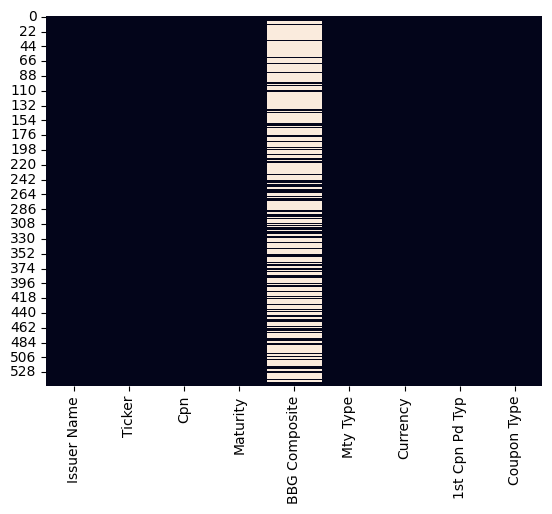

In [7]:
sns.heatmap(data.isnull(), cbar=False)

Since there is only one bond missing the `Cpn`value, we can drop that row.

<Axes: >

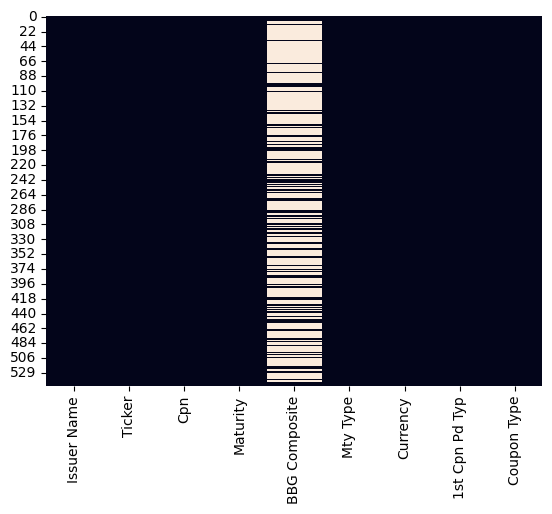

In [8]:
data = data.dropna(subset=['Cpn'])
sns.heatmap(data.isnull(), cbar=False)

We need to analyze the `BBG Composite` column

In [9]:
data['BBG Composite'].value_counts()

BB+     63
NR      39
BBB-    15
BB-     12
B       10
B+      10
BBB      6
B-       5
BB       4
AA       2
Name: BBG Composite, dtype: int64

As the column represents credit score ratings according to Bloomberg, we aim to create a function that iterates through the DataFrame, filling in missing values in the 'BBG Composite' column based on the values for the same 'issuer' in other bonds. If some bonds still have missing credit ratings after this process, we will then assign the same 'BB+' grading as the country (Colombia). In summary, the function ensures that bonds from the same issuer have consistent credit ratings, and if any remain unclassified, they are assigned the default rating of 'BB+' for Colombia.

In [10]:
def fill_missing_bbg_composite(df):
    # Create a mapping of 'issuer' to the most frequent 'BBG_composite' value
    issuer_to_mode_bbg = df.groupby('Issuer Name')['BBG Composite'].agg(lambda x: x.mode().iat[0] if not x.mode().empty else None).to_dict()

    # Iterate through the DataFrame and fill missing 'BBG_composite' values
    for index, row in df.iterrows():
        if pd.isna(row['BBG Composite']):
            issuer = row['Issuer Name']
            if issuer in issuer_to_mode_bbg:
                df.at[index, 'BBG Composite'] = issuer_to_mode_bbg[issuer]

    # Assign 'BB+' grading to rows with still missing 'BBG_composite' values
    df['BBG Composite'].fillna('BB+', inplace=True)

<Axes: >

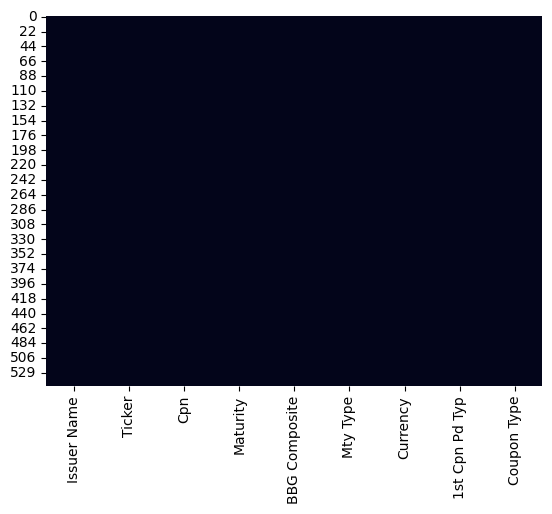

In [11]:
fill_missing_bbg_composite(data)
sns.heatmap(data.isnull(), cbar=False)

### 1.3. Correcting Values

It is important to explore the values of other columns in the dataframe to check for strange/bad values and change them

In [12]:
# Exploring the values in columns
for column in data.columns:
  print(column)
  print(data[column].value_counts())
  print()

Issuer Name
Colombia Government International Bond     55
Banco Davivienda SA                        33
Interconexion Electrica SA ESP             24
Colombian TES                              21
Isagen SA ESP                              17
                                           ..
Inversiones JMH SAS                         1
Banco Colpatria Multibanca Colpatria SA     1
Trayectoria Oil & Gas SA                    1
Alpina Productos Alimenticios SA            1
Avista Colombia SAS                         1
Name: Issuer Name, Length: 101, dtype: int64

Ticker
COLOM     55
DAVIVI    33
ISACB     24
COLTES    21
EEPPME    17
          ..
ALPINA     1
BNSCN      1
BMUJER     1
BANCW      1
BCAMIA     1
Name: Ticker, Length: 93, dtype: int64

Cpn
6.250000     12
7.000000     11
9.000000      8
4.375000      8
5.750000      8
             ..
15.160448     1
4.830000      1
16.013300     1
6.740000      1
21.154850     1
Name: Cpn, Length: 358, dtype: int64

Maturity
26/03/2031    6
2/0

`Maturity` and `1st Cpn Pd Typ` columns both have a '#N/A Field Not Applicable' in a few number of rows. Since this value is not that common, we can remove those rows without any problem.

In [13]:
data = data[data['Maturity'] != '#N/A Field Not Applicable']
data = data[data['1st Cpn Pd Typ'] != '#N/A Field Not Applicable']

In [14]:
data.size

4878

After all the cleaning, we still have 4878 values.

### 1.4. Correcting Data Types

Lets check the data types of the columns

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542 entries, 2 to 548
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Issuer Name     542 non-null    object 
 1   Ticker          542 non-null    object 
 2   Cpn             542 non-null    float64
 3   Maturity        542 non-null    object 
 4   BBG Composite   542 non-null    object 
 5   Mty Type        542 non-null    object 
 6   Currency        542 non-null    object 
 7   1st Cpn Pd Typ  542 non-null    object 
 8   Coupon Type     542 non-null    object 
dtypes: float64(1), object(8)
memory usage: 42.3+ KB


In [16]:
data.head()

,Issuer Name,Ticker,Cpn,Maturity,BBG Composite,Mty Type,Currency,1st Cpn Pd Typ,Coupon Type
2,Transtel Pass Through Trust,TRNTEL,12.5,1/11/2007,NR,CALLABLE,USD,Normal,DEFAULTED
3,Transtel Pass Through Trust,TRNTEL,12.5,1/11/2007,NR,CALLABLE,USD,Normal,DEFAULTED
4,Transtel Pass Through Trust,TRNTEL,12.5,1/11/2007,NR,CALLABLE,USD,Normal,DEFAULTED
5,Transtel Intermedia SA,TRNTEL,12.0,1/06/2016,NR,AT MATURITY,USD,Normal,DEFAULTED
6,Transtel Intermedia SA,TRNTEL,12.0,1/06/2016,NR,AT MATURITY,USD,Normal,DEFAULTED


Maturity should be in datetime format

In [17]:
# Changing data type of maturity column
data['Maturity'] = pd.to_datetime(data['Maturity'])

<ipython-input-17-d067a99ef032>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['Maturity'] = pd.to_datetime(data['Maturity'])


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542 entries, 2 to 548
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Issuer Name     542 non-null    object        
 1   Ticker          542 non-null    object        
 2   Cpn             542 non-null    float64       
 3   Maturity        542 non-null    datetime64[ns]
 4   BBG Composite   542 non-null    object        
 5   Mty Type        542 non-null    object        
 6   Currency        542 non-null    object        
 7   1st Cpn Pd Typ  542 non-null    object        
 8   Coupon Type     542 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 42.3+ KB


## 2. Preprocessing

### 2.1 Ordinal Encoding

We will start by preprocessing categorical columns that can be aranged according to a scale. The only column with this characteristics is: `BBG Composite`

In [19]:
data['BBG Composite'].value_counts()

BB+     346
NR       42
B        41
BBB      36
BBB-     27
BB-      26
B+       11
B-        7
BB        4
AA        2
Name: BBG Composite, dtype: int64

In [20]:
ordinal_scale= [[
    "AA",
    "BB+",
    "BB",
    "BB-",
    "B+",
    "B",
    "B-",
    "BBB-",
    "BBB",
    "NR"
]]

data['BBG Composite'] = OrdinalEncoder(categories=ordinal_scale).fit_transform(data[['BBG Composite']] )

### 2.2 One-Hot Encoding

The rest of the columns that correspond to attributes will be stored as dummies

In [21]:
# Selecting columns for the classification
preprocessed_df=data[['Cpn', 'BBG Composite', 'Mty Type', 'Currency', '1st Cpn Pd Typ', 'Coupon Type']]

In [22]:
# One hot encoding for all 'object' type columns
preprocessed_df=pd.get_dummies(data=preprocessed_df,columns=preprocessed_df.select_dtypes(include='object').columns, drop_first=True)

In [23]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542 entries, 2 to 548
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cpn                         542 non-null    float64
 1   BBG Composite               542 non-null    float64
 2   Mty Type_CALL/SINK          542 non-null    uint8  
 3   Mty Type_CALLABLE           542 non-null    uint8  
 4   Mty Type_CONV/CALL          542 non-null    uint8  
 5   Mty Type_SINKABLE           542 non-null    uint8  
 6   Currency_CAD                542 non-null    uint8  
 7   Currency_COP                542 non-null    uint8  
 8   Currency_EUR                542 non-null    uint8  
 9   Currency_USD                542 non-null    uint8  
 10  1st Cpn Pd Typ_Normal       542 non-null    uint8  
 11  1st Cpn Pd Typ_Short First  542 non-null    uint8  
 12  Coupon Type_FIXED           542 non-null    uint8  
 13  Coupon Type_FLOATING        542 non

## 3. Training the model

In [24]:
kmeans = KMeans(n_clusters=3) # create a k-means object with 3 clusters
kmeans.fit(preprocessed_df) # fit the model to the data

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [25]:
data['labels']=kmeans.labels_
preprocessed_df['labels']=kmeans.labels_

In [26]:
data.head()

,Issuer Name,Ticker,Cpn,Maturity,BBG Composite,Mty Type,Currency,1st Cpn Pd Typ,Coupon Type,labels
2,Transtel Pass Through Trust,TRNTEL,12.5,2007-01-11,9.0,CALLABLE,USD,Normal,DEFAULTED,1
3,Transtel Pass Through Trust,TRNTEL,12.5,2007-01-11,9.0,CALLABLE,USD,Normal,DEFAULTED,1
4,Transtel Pass Through Trust,TRNTEL,12.5,2007-01-11,9.0,CALLABLE,USD,Normal,DEFAULTED,1
5,Transtel Intermedia SA,TRNTEL,12.0,2016-01-06,9.0,AT MATURITY,USD,Normal,DEFAULTED,1
6,Transtel Intermedia SA,TRNTEL,12.0,2016-01-06,9.0,AT MATURITY,USD,Normal,DEFAULTED,1


In [27]:
cluster_stats = preprocessed_df.groupby('labels').agg({'Cpn': 'mean', 'BBG Composite': 'mean'})
print(cluster_stats)

              Cpn  BBG Composite
labels                          
0       17.416304       2.182156
1        6.567030       7.524752
2        6.235239       1.343023


According to the labels, cluster 0 includes bonds with low risk while labels 1 and 2 include bonds with high risk. The expected returns according for cluster 2 are higher tan for cluster 1.


After analyzing the model, the recommendation for an investor would be thefollowing:
* Conservative investor: consifer looking for bonds with label 0
* Agressive Investor: consider looking for bonds with label 2

In [28]:
# Recommendation for conservative investor
conservative = data[data['labels']==0]

In [29]:
conservative.describe()

,Cpn,BBG Composite,labels
count,269.000000,269.000000,269.0
mean,17.416304,2.182156,0.0
std,1.732561,2.288904,0.0
min,12.500000,1.000000,0.0
25%,16.738100,1.000000,0.0
50%,17.629952,1.000000,0.0
75%,18.088946,1.000000,0.0
max,27.326720,8.000000,0.0


In [30]:
conservative.head()

,Issuer Name,Ticker,Cpn,Maturity,BBG Composite,Mty Type,Currency,1st Cpn Pd Typ,Coupon Type,labels
9,Trayectoria Oil & Gas SA,TRAYOG,12.500000,2017-04-15,1.0,SINKABLE,USD,Long First,DEFAULTED,0
10,Enel Colombia SA ESP,EMGSA,16.491056,2022-12-13,1.0,AT MATURITY,COP,Normal,FLOATING,0
13,Grupo de Inversiones Suramericana SA,GRUPOS,17.646920,2023-07-05,1.0,AT MATURITY,COP,Normal,FLOATING,0
14,Banco Popular SA,BCOPOP,16.738100,2023-08-05,1.0,AT MATURITY,COP,Normal,FLOATING,0
17,Banco de Comercio Exterior de Colombia SA,BANDEX,16.570190,2023-05-24,1.0,AT MATURITY,COP,Normal,FLOATING,0


In [31]:
# Recommendation for aggressive investor
aggressive = data[data['labels']==2]

In [32]:
aggressive.describe()

,Cpn,BBG Composite,labels
count,172.000000,172.000000,172.0
mean,6.235239,1.343023,2.0
std,1.852622,0.881126,0.0
min,2.100000,0.000000,2.0
25%,4.875000,1.000000,2.0
50%,6.245000,1.000000,2.0
75%,7.250000,1.000000,2.0
max,11.850000,4.000000,2.0


In [33]:
aggressive.head()

,Issuer Name,Ticker,Cpn,Maturity,BBG Composite,Mty Type,Currency,1st Cpn Pd Typ,Coupon Type,labels
11,Gilex Holding Sarl,GILHDG,8.50,2023-02-05,4.0,CALLABLE,USD,Normal,FIXED,2
12,Gilex Holding Sarl,GILHDG,8.50,2023-02-05,4.0,CALLABLE,USD,Normal,FIXED,2
15,Banco Popular SA,BCOPOP,6.68,2023-08-05,1.0,AT MATURITY,COP,Normal,FIXED,2
16,Cementos Argos SA,CEMCAR,6.65,2023-05-24,1.0,AT MATURITY,COP,Normal,FIXED,2
18,Banco de Comercio Exterior de Colombia SA,BANDEX,4.35,2023-05-27,1.0,AT MATURITY,COP,Normal,FIXED,2
